# Imports

In [2]:
import os
from PIL import Image, ImageOps
import pandas as pd
import numpy as np
from tqdm import tqdm
import cv2
import imutils
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras import layers, models
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications import ResNet50
import matplotlib.cm as cm
from tf_keras_vis.gradcam import Gradcam
from tf_keras_vis.utils import normalize
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from tensorflow.keras.utils import to_categorical

2023-11-25 19:30:53.465710: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.


# Simple Detection Model

# Data Loading

In [2]:
def display_image(image_path):
    img = Image.open(image_path)
    img.show()

yes_path = './data/yes'
no_path = "./data/no"

In [3]:
def create_dataframe(yes_path, no_path):
    # Initialize an empty list to store the data
    data = []

    # Process 'yes' images
    for image in os.listdir(yes_path):
        data.append({
            "image_path": os.path.join(yes_path, image),
            "tumor_present": "yes"
        })

    # Process 'no' images
    for image in os.listdir(no_path):
        data.append({
            "image_path": os.path.join(no_path, image),
            "tumor_present": "no"
        })

    # Create a DataFrame
    df = pd.DataFrame(data)

    return df

## Train, Test, Validation Splits

In [7]:
def create_train_test_val_splits(df, test_size=0.2, val_size=0.1):

    # First, split into training + validation and test sets
    train_val_df, test_df = train_test_split(df, test_size=test_size, random_state=42)

    # Adjust val_size to compensate for the initial split
    adjusted_val_size = val_size / (1 - test_size)

    # Then, split the training + validation set into training and validation sets
    train_df, val_df = train_test_split(train_val_df, test_size=adjusted_val_size, random_state=42)

    return train_df, val_df, test_df

In [5]:
total_data = create_dataframe(yes_path, no_path)
total_data = total_data.sample(frac=1).reset_index(drop=True)

In [6]:
# Shuffle and split the data
train_data, val_data, test_data = create_train_test_val_splits(total_data)

# Display the sizes of each set
print(f"Training Set: {len(train_data)}")
print(f"Validation Set: {len(val_data)}")
print(f"Test Set: {len(test_data)}")

print(train_data.head())

Training Set: 2100
Validation Set: 300
Test Set: 600
                image_path tumor_present
921   ./data/yes/y1134.jpg           yes
339    ./data/yes/y581.jpg           yes
1984    ./data/yes/y63.jpg           yes
2439   ./data/yes/y237.jpg           yes
259    ./data/yes/y932.jpg           yes


# Make images the same size and normalize

In [7]:
# Global counter for images that are excluded
excluded_images_count = 0
all_images = 0

def preprocess_image(image_path, target_size):
    global excluded_images_count
    global all_images
    all_images += 1

    try:
        img = Image.open(image_path)
        img = ImageOps.fit(img, target_size, Image.Resampling.LANCZOS)  # Resizing with LANCZOS
        img = np.array(img)
        if img.shape != (target_size[0], target_size[1], 3):  # Check if image has three color channels
            excluded_images_count += 1
            return None
        img = img / 255.0  # Normalize pixel values
        return img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        excluded_images_count += 1
        return None

def encode_label(label):
    return 1 if label == 'yes' else 0

def prepare_dataset(df, target_size=(224, 224)):
    images = df['image_path'].apply(lambda x: preprocess_image(x, target_size)).dropna()
    labels = df['tumor_present'][images.index].apply(encode_label)  # Align labels with images
    return np.array(images.tolist()), np.array(labels)

In [8]:
def show_sample_images(data, preprocess_func, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = preprocess_func(data.iloc[i]['image_path'], (224, 224))
        plt.imshow(img)
        plt.title(data.iloc[i]['tumor_present'])
        plt.axis("off")

# Prepare Data and Visualize some samples

Total images excluded: 109
all images : 3005


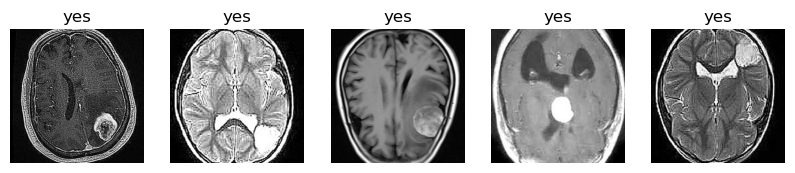

In [9]:
X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

show_sample_images(train_data, preprocess_image)


print(f"Total images excluded: {excluded_images_count}")
print(f"all images : {all_images}")

# Custom Model

In [10]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(224, 224, 3)),  # Adjusted input shape
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, name="final_conv_layer"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()
# Model Compilation
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Model Training using Validation Data
history = model.fit(X_train, y_train, batch_size=35, epochs=5, verbose=1, validation_data=(X_val, y_val))


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 112, 112, 32)      0         
 D)                                                              
                                                                 
 final_conv_layer (Conv2D)   (None, 112, 112, 32)      9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 56, 56, 32)        0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 56, 56, 32)        0         
                                                                 
 flatten (Flatten)           (None, 100352)            0

## Analysis

Text(0.5, 1.0, 'Loss over Epochs')

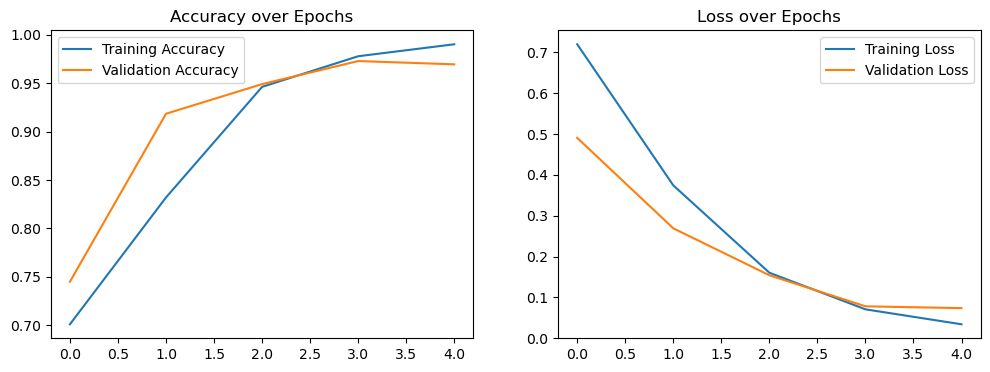

In [11]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

### Heat Maps

In [12]:
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    gradcam = Gradcam(model, model_modifier=None, clone=False)
    cam = gradcam(
        lambda output: output[pred_index] if pred_index else output,
        img_array,
        penultimate_layer=-1,
    )
    heatmap = normalize(cam)
    return heatmap

In [13]:
def show_images_with_heatmaps(image_paths, model, preprocess_func, last_conv_layer_name):
    plt.figure(figsize=(10, 10))

    for i, image_path in enumerate(image_paths):
        # Original image
        original_img = preprocess_func(image_path, (224, 224))
        ax = plt.subplot(5, 2, 2 * i + 1)
        plt.imshow(original_img)
        plt.title(f"Original - {image_path.split('/')[-1]}")
        plt.axis('off')

        img_array = np.array([original_img])
        heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)
        ax = plt.subplot(5, 2, 2 * i + 2)
        plt.imshow(original_img)
        plt.imshow(heatmap.squeeze(), cmap='jet', alpha=0.5)  
        plt.title("Heatmap")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

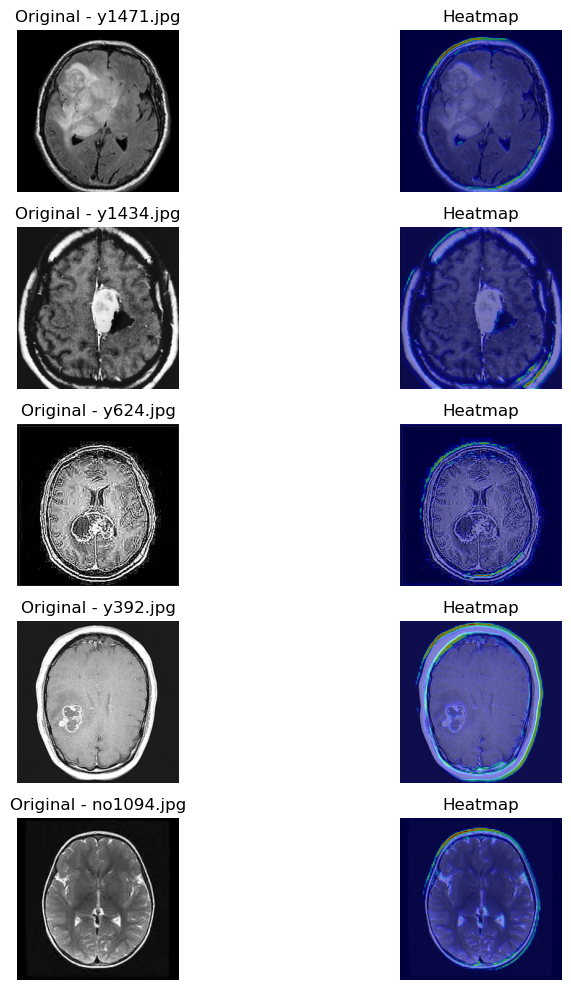

In [14]:
image_paths = [
    './data/yes/y1471.jpg',
    './data/yes/y1434.jpg',
    './data/yes/y624.jpg',
    './data/yes/y392.jpg',
    './data/no/no1094.jpg'
]

show_images_with_heatmaps(image_paths, model, preprocess_image, 'conv2d_4')

In [15]:
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

18/18 [==============================] - 5s 249ms/step - loss: 0.0734 - accuracy: 0.9721
Test Loss: 0.07341913133859634
Test Accuracy: 0.9721254110336304


### Confusion Matrix

In [16]:
def confusion_mat(true_classes, predicted_classes, tumor_types):
    cm = confusion_matrix(true_classes, predicted_classes)

    # Plot the confusion matrix
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', xticklabels=tumor_types, yticklabels=tumor_types)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix')
    plt.show()

In [17]:
test_predictions = np.round(model.predict(X_test).flatten())
binary_tumor_types = ['yes', 'no']

18/18 [==============================] - 4s 223ms/step


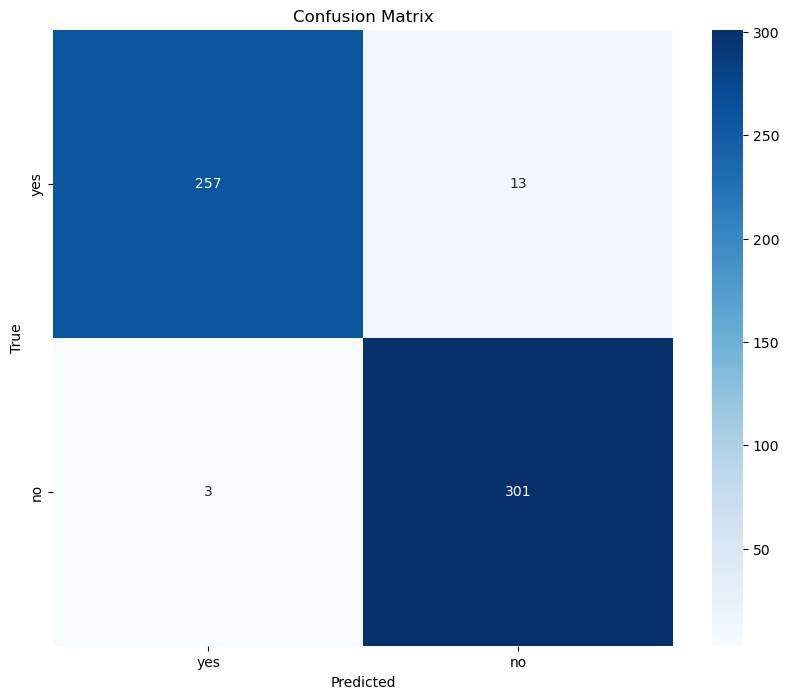

In [18]:
confusion_mat(y_test, test_predictions, binary_tumor_types)

In [19]:
report_simple = classification_report(y_test, test_predictions, target_names=binary_tumor_types)
print(report_simple)

              precision    recall  f1-score   support

         yes       0.99      0.95      0.97       270
          no       0.96      0.99      0.97       304

    accuracy                           0.97       574
   macro avg       0.97      0.97      0.97       574
weighted avg       0.97      0.97      0.97       574



# VGG16 Model

In [20]:
# Load VGG16 pre-trained on ImageNet data
base_model = VGG16(weights='imagenet', include_top=False, input_tensor=Input(shape=(224, 224, 3)))

# Freeze the base_model
base_model.trainable = False

# Add custom layers on top of VGG16 base
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation='sigmoid')(x)

# This is the model we will train
vgg_model = Model(inputs=base_model.input, outputs=predictions)

# Compile the model
vgg_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

vgg_model.summary()

# Train the model
vgg_history = vgg_model.fit(X_train, y_train, batch_size=35, epochs=5, verbose=1, validation_data=(X_val, y_val))

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

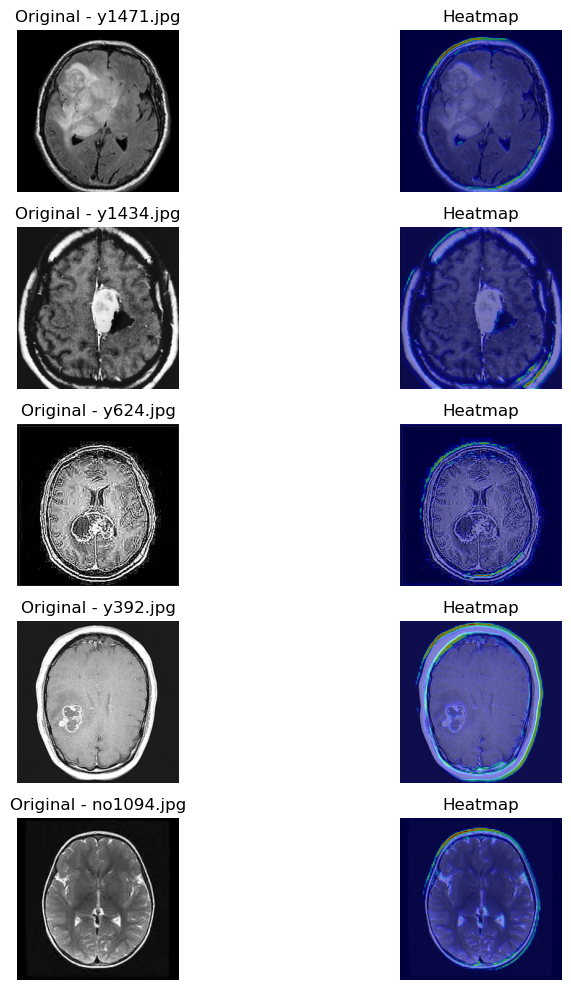

In [21]:
show_images_with_heatmaps(image_paths, model, preprocess_image, 'block5_conv3')

In [22]:
vgg_test_loss, vgg_test_accuracy = vgg_model.evaluate(X_test, y_test)

print(f"VGG16 Model - Test Loss: {vgg_test_loss}, Test Accuracy: {vgg_test_accuracy}")

18/18 [==============================] - 91s 5s/step - loss: 0.3292 - accuracy: 0.8484
VGG16 Model - Test Loss: 0.3291521370410919, Test Accuracy: 0.8484320640563965


### Confusion Matrix

In [23]:
test_predictions_vgg = np.round(vgg_model.predict(X_test).flatten())

18/18 [==============================] - 89s 5s/step


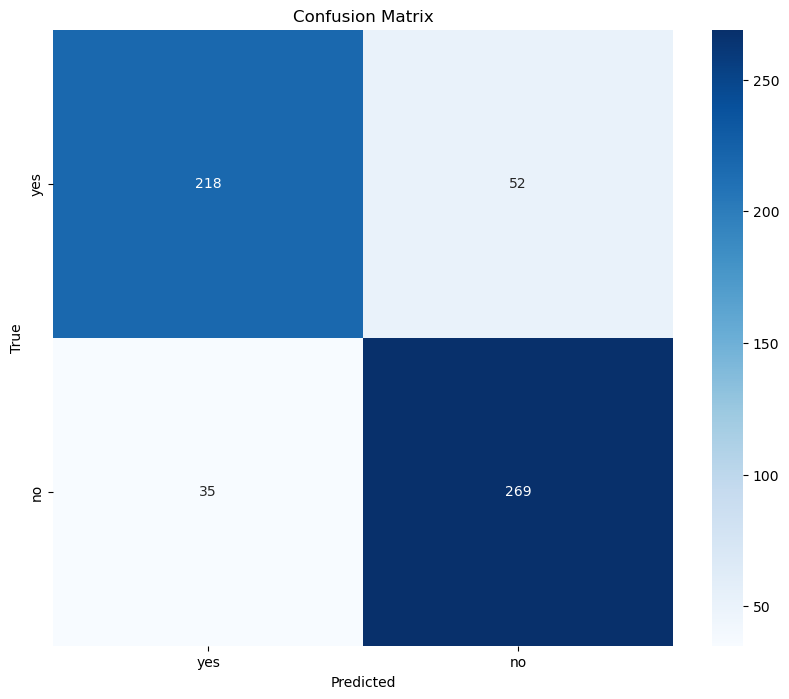

In [24]:
confusion_mat(y_test, test_predictions_vgg, binary_tumor_types)

In [25]:
report_vgg = classification_report(y_test, test_predictions_vgg, target_names=binary_tumor_types)
print(report_vgg)

              precision    recall  f1-score   support

         yes       0.86      0.81      0.83       270
          no       0.84      0.88      0.86       304

    accuracy                           0.85       574
   macro avg       0.85      0.85      0.85       574
weighted avg       0.85      0.85      0.85       574



## ResNet50 Model

### Train Model

In [26]:
resnet_model_detect = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model_detect.trainable = False

In [27]:
resnet_model_detect = Sequential([
    resnet_model_detect,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

In [28]:
resnet_model_detect.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

### Fit and Evaluate Model

In [29]:
# Train the model
history = resnet_model_detect.fit(X_train, y_train, batch_size=35, epochs=5, verbose=1, validation_data=(X_val, y_val))

Epoch 1/5
58/58 [==============================] - 191s 3s/step - loss: 2.4532 - accuracy: 0.6273 - val_loss: 0.6099 - val_accuracy: 0.7449
Epoch 2/5
58/58 [==============================] - 181s 3s/step - loss: 0.5644 - accuracy: 0.7133 - val_loss: 0.5634 - val_accuracy: 0.7177
Epoch 3/5
58/58 [==============================] - 178s 3s/step - loss: 0.5730 - accuracy: 0.7074 - val_loss: 0.5728 - val_accuracy: 0.7041
Epoch 4/5
58/58 [==============================] - 172s 3s/step - loss: 0.5677 - accuracy: 0.7069 - val_loss: 0.5550 - val_accuracy: 0.6973
Epoch 5/5
58/58 [==============================] - 172s 3s/step - loss: 0.5460 - accuracy: 0.7222 - val_loss: 0.5730 - val_accuracy: 0.7007


In [30]:
# Evaluate the model
test_loss, test_acc = resnet_model_detect.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc*100:.2f}%")

18/18 [==============================] - 46s 3s/step - loss: 0.5179 - accuracy: 0.7282
Test Accuracy: 72.82%


### Analyze Results

In [31]:
test_predictions = np.round(resnet_model_detect.predict(X_test).flatten())

18/18 [==============================] - 41s 2s/step


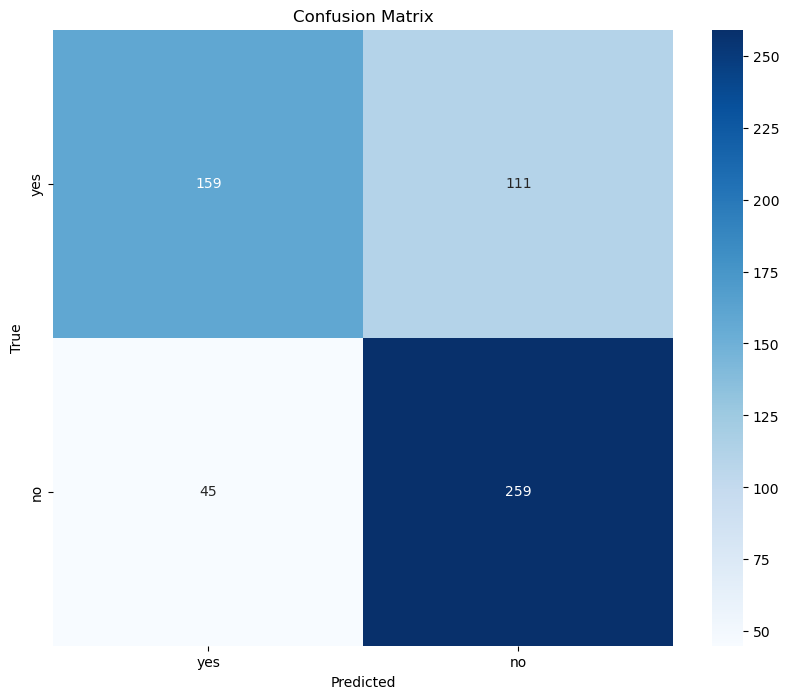

In [32]:
confusion_mat(y_test, test_predictions, binary_tumor_types)

In [33]:
report_resnet = classification_report(y_test, test_predictions, target_names=binary_tumor_types)
print(report_resnet)

              precision    recall  f1-score   support

         yes       0.78      0.59      0.67       270
          no       0.70      0.85      0.77       304

    accuracy                           0.73       574
   macro avg       0.74      0.72      0.72       574
weighted avg       0.74      0.73      0.72       574



## Creating ROC Curves

In [34]:
# Predict probabilities
custom_probs = model.predict(X_test).ravel()
vgg_probs = vgg_model.predict(X_test).ravel()
resnet_probs = resnet_model_detect.predict(X_test).ravel()

# Calculate AUC
custom_auc = roc_auc_score(y_test, custom_probs)
vgg_auc = roc_auc_score(y_test, vgg_probs)
resnet_auc = roc_auc_score(y_test, resnet_probs)
print(f"Custom Model AUC: {custom_auc:.4f}, VGG Model AUC: {vgg_auc:.4f}, ResNet50 Model AUC: {resnet_auc:.4f}")

18/18 [==============================] - 43s 2s/step
Custom Model AUC: 0.9960, VGG Model AUC: 0.9434, ResNet50 Model AUC: 0.8575


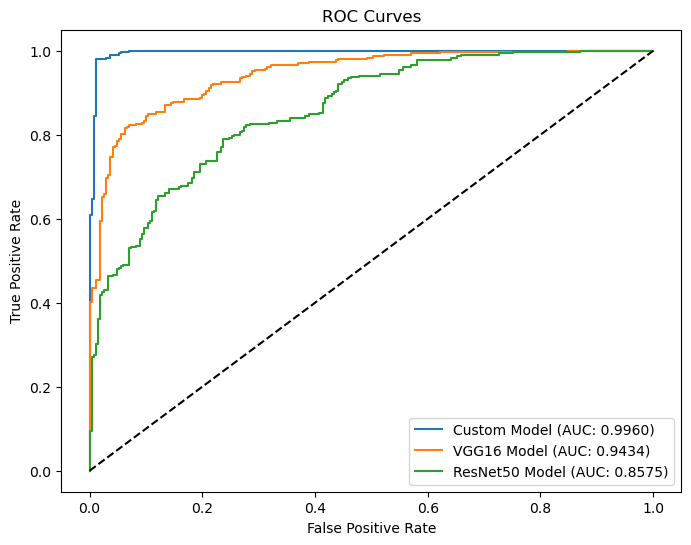

In [35]:
def plot_roc_curve(y_true, y_prob, model_name):
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.plot(fpr, tpr, label=f"{model_name} (AUC: {roc_auc_score(y_true, y_prob):.4f})")

plt.figure(figsize=(8, 6))
plot_roc_curve(y_test, custom_probs, "Custom Model")
plot_roc_curve(y_test, vgg_probs, "VGG16 Model")
plot_roc_curve(y_test, resnet_probs, "ResNet50 Model")
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves')
plt.legend()
plt.show()

# Classification Model

## Data Loading

In [3]:
def display_image(image_path):
    img = Image.open(image_path)
    img.show()

giloma_path = './data/classification_data/giloma'
meningioma_path = "./data/classification_data/meningioma"
pituitary_path = "./data/classification_data/pituitary"
no_tumor_path = "./data/classification_data/notumor"

In [4]:
def create_dataframe(giloma_path, meningioma_path, pituitary_path, no_tumor_path):
    # Initialize an empty list to store the data
    data = []

    # Process 'giloma' images
    for image in os.listdir(giloma_path):
        data.append({
            "image_path": os.path.join(giloma_path, image),
            "tumor_type": "giloma"
        })

    # Process 'meningioma' images
    for image in os.listdir(meningioma_path):
        data.append({
            "image_path": os.path.join(meningioma_path, image),
            "tumor_type": "meningioma"
        })
        
    # Process 'pituitary' images
    for image in os.listdir(pituitary_path):
        data.append({
            "image_path": os.path.join(pituitary_path, image),
            "tumor_type": "pituitary"
        })

    # Process 'no tumor' images
    for image in os.listdir(no_tumor_path):
        data.append({
            "image_path": os.path.join(no_tumor_path, image),
            "tumor_type": "no tumor"
        })

    # Create a DataFrame
    df = pd.DataFrame(data)

    return df

## Train, Test, Validation Splits

In [5]:
total_data = create_dataframe(giloma_path, meningioma_path, pituitary_path, no_tumor_path)
total_data = total_data.sample(frac=1).reset_index(drop=True)

In [8]:
# Shuffle and split the data
train_data, val_data, test_data = create_train_test_val_splits(total_data)

# Display the sizes of each set
print(f"Training Set: {len(train_data)}")
print(f"Validation Set: {len(val_data)}")
print(f"Test Set: {len(test_data)}")

print(train_data.head())

Training Set: 4915
Validation Set: 703
Test Set: 1405
                                             image_path  tumor_type
5117  ./data/classification_data/pituitary/Tr-pi_039...   pituitary
2727   ./data/classification_data/giloma/Tr-gl_1098.jpg      giloma
6133  ./data/classification_data/notumor/Tr-no_0145.jpg    no tumor
908   ./data/classification_data/meningioma/Tr-me_09...  meningioma
953   ./data/classification_data/pituitary/Tr-pi_009...   pituitary


## Make images the same size and normalize

We use the preprocessing code provided by the dataset: 
https://github.com/masoudnick/Brain-Tumor-MRI-Classification/blob/main/Preprocessing.py

In [9]:
# Global counter for images that are excluded
excluded_images_count = 0
all_images = 0

# Using preprocessing code provided with the dataset
def preprocess_image(image_path, image_size=(256,256)):
    global excluded_images_count
    global all_images
    all_images += 1

    try:
        img = cv2.imread(image_path)
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (3, 3), 0)
        
        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)
        
        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)
        
        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])
        ADD_PIXELS = 0
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        new_img = cv2.resize(new_img, image_size)
        return new_img
    except Exception as e:
        print(f"Error processing image {image_path}: {e}")
        excluded_images_count += 1
        return None
    
def encode_label(label):
    if label == "giloma":
        return 0
    elif label == "meningioma":
        return 1
    elif label == "pituitary":
        return 2
    else:
        return 3
    
def prepare_dataset(df):
    images = df['image_path'].apply(lambda x: preprocess_image(x)).dropna()
    labels = df['tumor_type'][images.index].apply(encode_label)  # Align labels with images
    return np.array(images.tolist()), np.array(labels)

In [10]:
def show_sample_images(data, preprocess_func, num_images=5):
    plt.figure(figsize=(10, 10))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = preprocess_func(data.iloc[i]['image_path'])
        plt.imshow(img)
        plt.title(data.iloc[i]['tumor_type'])
        plt.axis("off")

Total images excluded: 0
all images : 7028


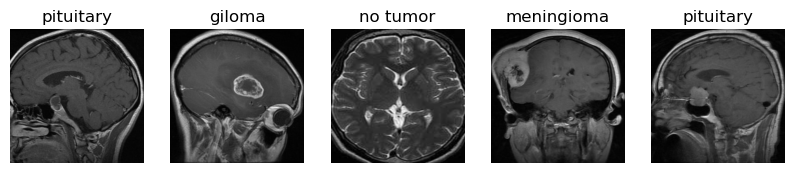

In [11]:
X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

show_sample_images(train_data, preprocess_image)


print(f"Total images excluded: {excluded_images_count}")
print(f"all images : {all_images}")

## Custom Model

In [12]:
num_classes = 4
model_detect = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu, input_shape=(256, 256, 3)),  # Adjusted input shape
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding='same', activation=tf.nn.relu),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation=tf.nn.relu),
    tf.keras.layers.Dense(num_classes, activation='softmax')
])

# Model Compilation
model_detect.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Model Training using Validation Data
history_detect = model_detect.fit(X_train, y_train, batch_size=16, epochs=5, verbose=1, validation_data=(X_val, y_val))

Epoch 1/5
308/308 [==============================] - 73s 234ms/step - loss: 46.5886 - accuracy: 0.6134 - val_loss: 0.7135 - val_accuracy: 0.7255
Epoch 2/5
308/308 [==============================] - 70s 228ms/step - loss: 0.5078 - accuracy: 0.8002 - val_loss: 0.5682 - val_accuracy: 0.7909
Epoch 3/5
308/308 [==============================] - 918s 3s/step - loss: 0.3117 - accuracy: 0.8867 - val_loss: 0.6142 - val_accuracy: 0.8165
Epoch 4/5
308/308 [==============================] - 70s 228ms/step - loss: 0.2417 - accuracy: 0.9131 - val_loss: 0.6621 - val_accuracy: 0.8065
Epoch 5/5
308/308 [==============================] - 70s 227ms/step - loss: 0.1633 - accuracy: 0.9402 - val_loss: 0.7022 - val_accuracy: 0.8279


Text(0.5, 1.0, 'Loss over Epochs')

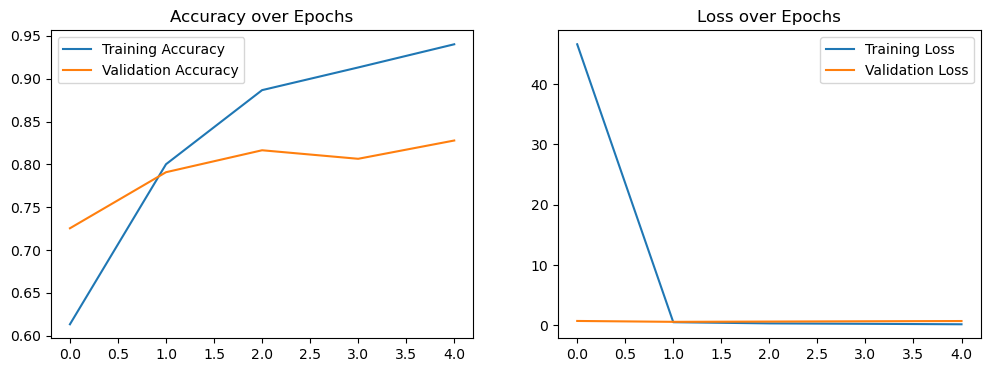

In [13]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_detect.history['accuracy'], label='Training Accuracy')
plt.plot(history_detect.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.subplot(1, 2, 2)
plt.plot(history_detect.history['loss'], label='Training Loss')
plt.plot(history_detect.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Loss over Epochs')

In [14]:
test_loss, test_accuracy = model_detect.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

44/44 [==============================] - 7s 152ms/step - loss: 0.5818 - accuracy: 0.8491
Test Loss: 0.5817639827728271
Test Accuracy: 0.8491103053092957


### Confusion Matrix

In [15]:
test_predictions_detect = model_detect.predict(X_test)
test_predictions_classes_detect = np.argmax(test_predictions_detect, axis=1)

tumor_types = ['giloma', 'meningioma', 'pituitary', 'no tumor']

44/44 [==============================] - 7s 150ms/step


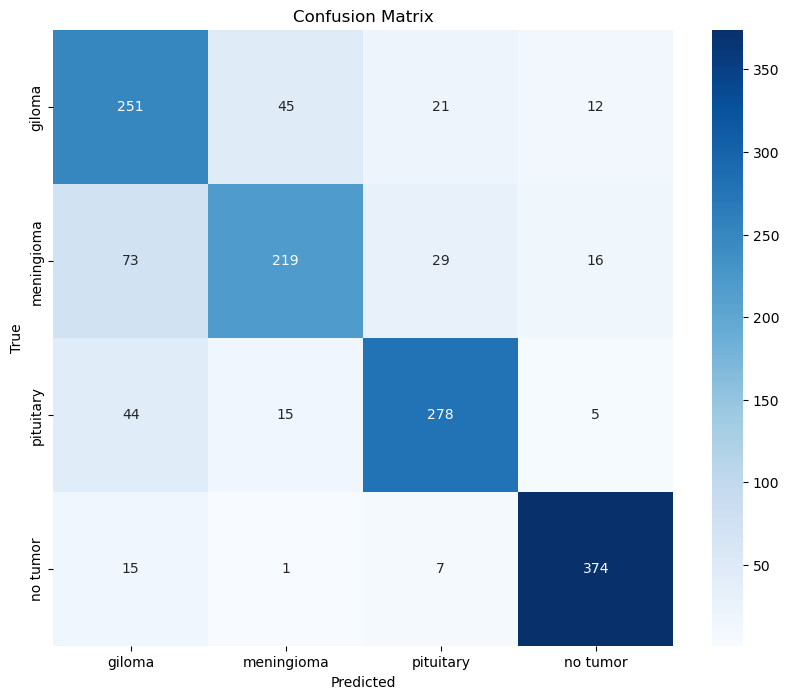

In [51]:
confusion_mat(y_test, test_predictions_classes_detect, tumor_types)

In [52]:
report_model_detect = classification_report(y_test, test_predictions_classes_detect, target_names=tumor_types)
print(report_model_detect)

              precision    recall  f1-score   support

      giloma       0.66      0.76      0.71       329
  meningioma       0.78      0.65      0.71       337
   pituitary       0.83      0.81      0.82       342
    no tumor       0.92      0.94      0.93       397

    accuracy                           0.80      1405
   macro avg       0.80      0.79      0.79      1405
weighted avg       0.80      0.80      0.80      1405



## ResNet50 Model

### Train Model

In [16]:
resnet_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
resnet_model.trainable = False

94765736/94765736 [==============================] - 17s 0us/step


In [17]:
resnet_model = Sequential([
    resnet_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(4, activation='softmax')
])

In [18]:
resnet_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [19]:
def preprocess_image_resnet50(image_path, target_size=(224, 224)):
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=target_size)
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    return preprocess_input(img_array)

In [20]:
def encode_label(label):
    label_mapping = {'giloma': 0, 'meningioma': 1, 'pituitary': 2, 'no tumor': 3}
    return to_categorical(label_mapping[label], num_classes=4)

In [21]:
def transform_dataset(dataframe, target_size=(224, 224)):
    images = []
    labels = []

    for _, row in dataframe.iterrows():
        processed_img = preprocess_image_resnet50(row['image_path'], target_size)
        images.append(processed_img)
        label = encode_label(row['tumor_type'])
        labels.append(label)

    # Convert lists to numpy arrays
    images = np.array(images)
    labels = np.array(labels)

    return images, labels

In [22]:
train_images, train_labels = transform_dataset(train_data)
val_images, val_labels = transform_dataset(val_data)
test_images, test_labels = transform_dataset(test_data)

### Fit and Evaluate Model

In [23]:
# Train the model
history = resnet_model.fit(train_images, train_labels, epochs=5, validation_data=(val_images, val_labels))

# Evaluate the model
test_loss, test_acc = resnet_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/5
154/154 [==============================] - 251s 2s/step - loss: 2.0849 - accuracy: 0.6926 - val_loss: 0.4371 - val_accuracy: 0.8478
Epoch 2/5
154/154 [==============================] - 248s 2s/step - loss: 0.5581 - accuracy: 0.7839 - val_loss: 0.4166 - val_accuracy: 0.8748
Epoch 3/5
154/154 [==============================] - 642s 4s/step - loss: 0.5135 - accuracy: 0.8108 - val_loss: 0.3809 - val_accuracy: 0.8691
Epoch 4/5
154/154 [==============================] - 255s 2s/step - loss: 0.4378 - accuracy: 0.8307 - val_loss: 0.2936 - val_accuracy: 0.8962
Epoch 5/5
44/44 [==============================] - 62s 1s/step - loss: 0.2767 - accuracy: 0.8982
Test Accuracy: 89.82%


In [24]:
test_predictions = resnet_model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

44/44 [==============================] - 62s 1s/step


### Analyze Results

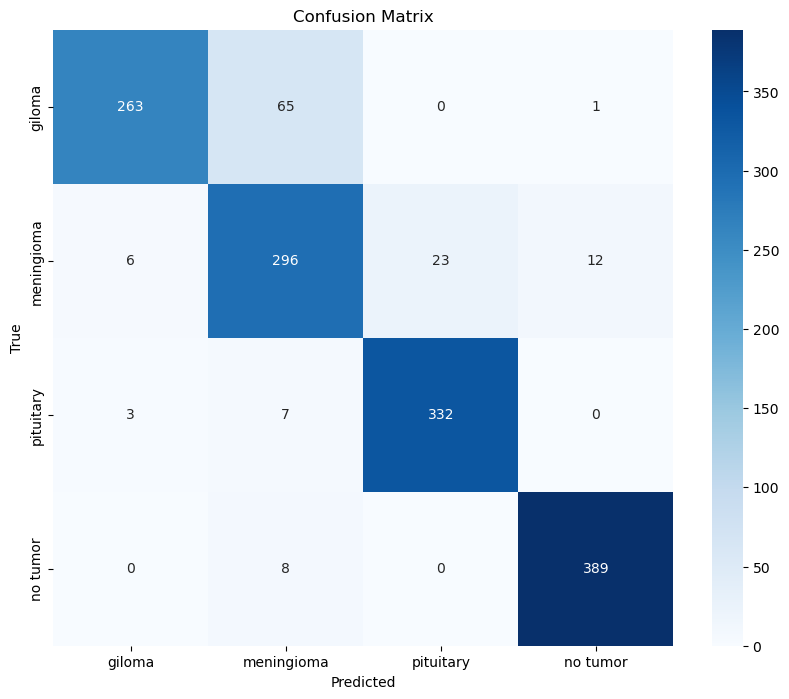

In [62]:
confusion_mat(test_true_classes, test_predictions_classes, tumor_types)

In [63]:
report_resnet = classification_report(test_true_classes, test_predictions_classes, target_names=tumor_types)
print(report_resnet)

              precision    recall  f1-score   support

      giloma       0.97      0.80      0.88       329
  meningioma       0.79      0.88      0.83       337
   pituitary       0.94      0.97      0.95       342
    no tumor       0.97      0.98      0.97       397

    accuracy                           0.91      1405
   macro avg       0.91      0.91      0.91      1405
weighted avg       0.92      0.91      0.91      1405



# Using Class Weights

In [64]:
class_weights = { 0: 2.,
                 1: 2.,
                 2: 2.,
                 3: 0.5
                }
# Train the model
history_with_weights = resnet_model.fit(train_images, train_labels, epochs=5, validation_data=(val_images, val_labels), class_weight=class_weights)

# Evaluate the model
test_loss, test_acc = resnet_model.evaluate(test_images, test_labels)
print(f"Test Accuracy: {test_acc*100:.2f}%")

Epoch 1/5
154/154 [==============================] - 458s 3s/step - loss: 0.8293 - accuracy: 0.8175 - val_loss: 0.2395 - val_accuracy: 0.9175
Epoch 2/5
154/154 [==============================] - 489s 3s/step - loss: 0.8284 - accuracy: 0.8212 - val_loss: 0.2064 - val_accuracy: 0.9289
Epoch 3/5
154/154 [==============================] - 424s 3s/step - loss: 0.7044 - accuracy: 0.8201 - val_loss: 0.2396 - val_accuracy: 0.9175
Epoch 4/5
154/154 [==============================] - 768s 5s/step - loss: 0.6318 - accuracy: 0.8442 - val_loss: 0.2156 - val_accuracy: 0.9232
Epoch 5/5
44/44 [==============================] - 107s 2s/step - loss: 0.2083 - accuracy: 0.9295
Test Accuracy: 92.95%


In [65]:
test_predictions = resnet_model.predict(test_images)
test_predictions_classes = np.argmax(test_predictions, axis=1)
test_true_classes = np.argmax(test_labels, axis=1)

tumor_types = ['giloma', 'meningioma', 'pituitary', 'no tumor']

44/44 [==============================] - 121s 3s/step


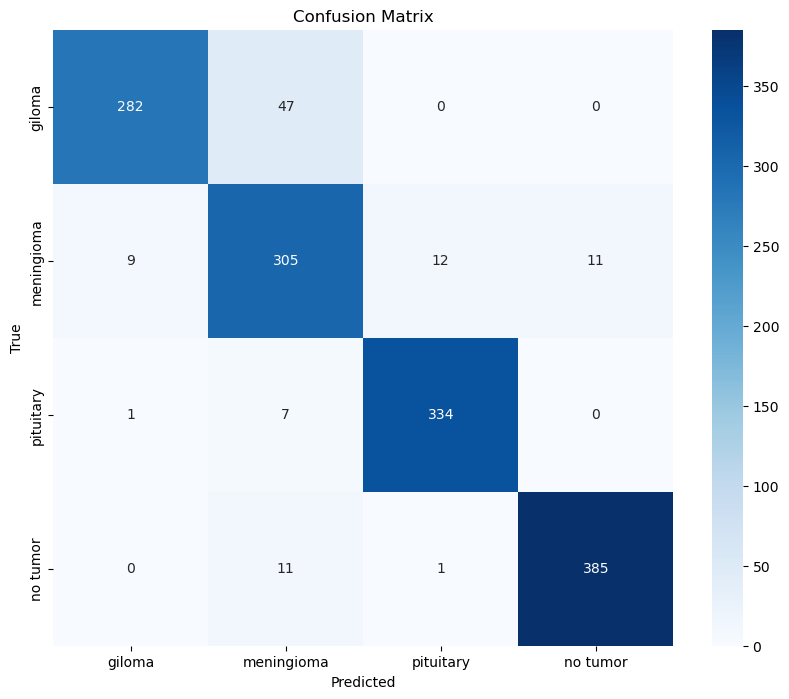

In [66]:
confusion_mat(test_true_classes, test_predictions_classes, tumor_types)

# Creating ROC curves

In [31]:
def plot_roc_curves(y_true, y_pred, classes, title):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_true[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    plt.figure(figsize=(10, 8))
    for i in range(len(classes)):
        plt.plot(fpr[i], tpr[i], label=f'ROC curve of class {classes[i]} (area = {roc_auc[i]:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

44/44 [==============================] - 62s 1s/step


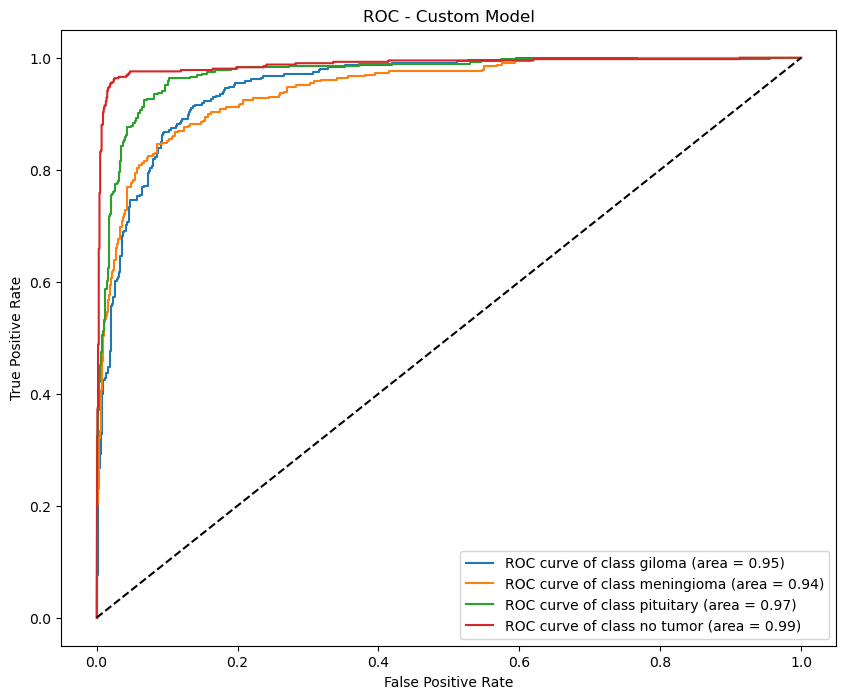

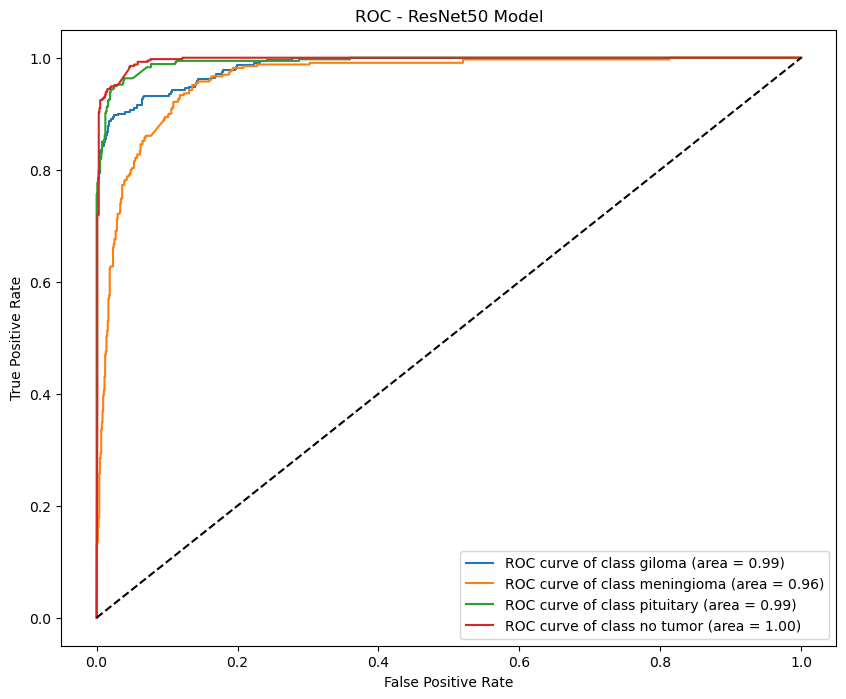

In [32]:
#Convert the test labels to categorical format
y_test_categorical = to_categorical(y_test, num_classes=num_classes)

#Predict probabilities
test_predictions_prob_detect = model_detect.predict(X_test)
test_predictions_prob_resnet = resnet_model.predict(test_images)

#Plot curves
plot_roc_curves(y_test_categorical, test_predictions_prob_detect, tumor_types, 'ROC - Custom Model')
plot_roc_curves(y_test_categorical, test_predictions_prob_resnet, tumor_types, 'ROC - ResNet50 Model')